In [11]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import requests
import math
from scipy.stats import norm

In [12]:
def getReqDate(d):
    start = pd.to_datetime(d)
    sYear = str(start.year)
    sMonth = ""
    sDay = ""
    
    if(start.month <10):
        sMonth = "0"+ str(start.month)
    else:
        sMonth = str(start.month)
    
    if(start.day <10):
        sDay = "0"+ str(start.day)
    else:
        sDay = str(start.day)
    
    output = sYear+sMonth+sDay+"T000000"
    return output

def getData(start,end,timeFrame,pair):
    access_token = ""
    headers = {'Authorization': 'Bearer ' + access_token}
    fromDate = getReqDate(start)
    toDate = getReqDate(end)
    url = "https://api.cryptoquant.com/v1/"+pair+"/market-data/price-ohlcv?window="+timeFrame+"&from="+fromDate+"&to="+toDate+"&limit=100000"
    temp = pd.DataFrame(requests.get(url, headers=headers).json()['result']['data'])
    temp.sort_values(by = 'datetime',inplace=True)
    temp.index = pd.to_datetime(temp.datetime)
    check = pd.to_datetime(temp.index[0])
    check1 = pd.to_datetime(start)
    if check.year != check1.year or check.month != check1.month or check.day != check1.day:
        newEnd = check
        #print(newEnd)
        newDF = pd.concat([getData(start,newEnd,timeFrame,pair), temp])
        dupIndex = newDF.index.duplicated(keep="first")
        newDF = newDF[~dupIndex]
        newDF.sort_index(inplace=True)
        
        return newDF
    else:
        return temp

In [13]:
fileName = 'gvolsurface.csv'
df = pd.read_csv(fileName, dtype = 'str')
df.dropna(how='all', axis=1, inplace=True)
df = df[['Day', 'Days Left', 'atmMidIV']]
df['DaysLeft'] = pd.to_numeric(df['Days Left'])
df['atmMidIV'] = pd.to_numeric(df['atmMidIV'])
df = df.drop(columns=['Days Left'])
df = df.loc[df['DaysLeft'] == 31]

In [14]:
firstDay, _ = df.iloc[1].Day.split()
lastDate, _ = df.iloc[-1].Day.split()
year, month, day = lastDate.split('-')
lastDay = year + '-' + month + '-' + str(int(day)+1)
historicalData = getData(firstDay, lastDay, 'hour', 'btc')
historicalData = historicalData[['datetime', 'open', 'close']]

In [15]:
df['spot'] = np.nan
for i, row in df.iterrows():
    df.at[i, 'spot'] = historicalData.loc[row.Day].open

In [16]:
delta = 0.5
d1 = norm.ppf(delta)
df['gamma'] = norm.pdf(d1)/(df.spot*(df.atmMidIV/100)*np.sqrt(df.DaysLeft/365))
df['gammaMoney']  = (df.gamma*(df.spot*df.spot))/100
df['OptionsNeeded'] = 1000000/df.gammaMoney

In [17]:
df.to_csv('gammas.csv')  

<AxesSubplot:xlabel='Day', ylabel='atmMidIV'>

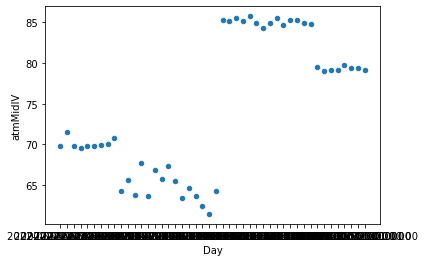

In [9]:
df = df.sort_values(by='spot',ascending=True)
df.plot('Day', 'atmMidIV', 'scatter')

In [10]:
btcFills['Timestamp'] = btcFills['Timestamp'].astype('datetime64[s]')
btcFills.sort_values(by = 'Timestamp',inplace = True)
#btcFills.index = btcFills['submitTime']
parentOrders = btcFills[btcFills['Group'].str.contains("Contingent")]
childOrders = btcFills[btcFills['Group'].str.contains("contingent/")]
childOrders['Timestamp'] = pd.to_datetime(childOrders['Timestamp'])
chains = {}
for i,r in parentOrders.iterrows():
    id = parentOrders.loc[i,'OrderID']
    data = [parentOrders.loc[i,'Timestamp'], parentOrders.loc[i,'Side'],parentOrders.loc[i,'AvgPx'], parentOrders.loc[i,'OrderID'],parentOrders.loc[i,'Group'],None]
    chains[id] = [order(data)]

temp = []
temp2 = []
for i in childOrders['Group']:
    temp.append(str(i.split('/')[1]))
    temp2.append(str(i.split('/')[2]))

childOrders['parents'] = temp
childOrders['prev'] = temp2

childOrders.index = childOrders.prev

NameError: name 'btcFills' is not defined